In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

import pymc as pm
import pytensor as pt
from pymc import PolyaGamma as PG

In [21]:
def _compute_mean_a(v, b, theta, w, y):
    S = torch.sum(torch.mul(theta, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()

def _compute_var_a(sigmasq, theta, w):
    S = torch.sum(torch.mul(w, torch.pow(theta, 2))) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_b(v, a, theta, w, y):
    S = torch.sum(y-0.5-a*torch.mul(theta, w))
    mean = v*S
    return mean.item()

def _compute_var_b(sigmasq, w):
    S = torch.sum(w) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_t(v, a, b, w, y):    
    S = torch.sum(torch.mul(a, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()    

def _compute_var_t(sigmasq, a, w):
    S = torch.sum(torch.mul(w, torch.pow(a, 2))) + 1/sigmasq
    print(S)
    var = 1/S

    print(w)        # FIXME: issue is that w has negative values -> sum, S, becomes negative -> var is negative
    print(a)
    return var.item()


def polyagamma(init_a, init_b, init_t, init_w, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):

    assert init_a.shape == init_b.shape
    assert init_t.shape[0] == y.shape[0]
    assert y.shape == init_w.shape
    
    I = len(init_a)
    P = len(init_t)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    W = torch.empty(size=(niter, P, I))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_t
    W[0] = init_w

    print(f"Starting Gibbs sampler for Polya-Gamma... \n--------------------------------------------\n")
    for s in trange(1, niter):

        # calculate scale values for PG draw
        Z = torch.mul(A[s-1, None], torch.t(THETA[s-1, None])) + B[s-1]
        assert Z.shape == (P, I)
        
        # sample Ws
        W[s] = torch.from_numpy(pm.draw(PG.dist(h=1, z=Z)))

        # sample As
        for i in range(I):
            var_a = _compute_var_a(sigmasq_a, THETA[s-1], W[s][:,i])
            mean_a = _compute_mean_a(var_a, B[s-1][i], THETA[s-1], W[s][:,i], y[:,i])
            A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()
            #try:
            #    A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()
            #except ValueError:
            #    A[s][i] = torch.distributions.Normal(mean_a, var_a+0.001).sample()

        # sample Bs
        for i in range(I):
            var_b = _compute_var_b(sigmasq_b, W[s][:,i])
            mean_b = _compute_mean_b(var_b, A[s][i], THETA[s-1], W[s][:,i], y[:,i])
            B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()
            #try: 
            #    B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()
            #except ValueError:
            #    B[s][i] = torch.distributions.Normal(mean_b, var_b+0.001).sample()

        # sample THETAs
        for p in range(P):
            var_t = _compute_var_t(sigmasq_t, W[s][p], A[s])
            mean_t = _compute_mean_t(var_t, A[s], B[s], W[s][p,:], y[p,:])
            THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()
            #try:
            #    THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()
            #except ValueError:
            #    var_t = torch.tensor([var_t + 0.0001])  
            #    THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()

    return A, B, THETA, W

In [3]:
# TEST

N = 1000   # iterations
I = 10     # exam items
P = 100    # pupils
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)
init_W = torch.zeros(P, I)

true_a, true_b = torch.empty(size=(I,)), torch.empty(size=(I,))  # items' difficulty and discriminatory power
true_theta = torch.empty(size=(P,))  # students' skills
true_W = torch.empty(size=(P,I))

# populate a, b:
for i in range(I):
    U1 = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U1.sample()
    
    U2 = torch.distributions.Uniform(torch.tensor([-1.0]), torch.tensor([0.0]))
    true_b[i] = U2.sample()

# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# populate W:
scales = torch.mul(torch.t(true_a[:, None]), true_theta[:, None]) + true_b
true_W = torch.from_numpy(pm.draw(PG.dist(h=1, z=scales)))
        
# exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] + true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] + true_b[i])) # trying +b
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],


In [23]:
#N=1000
samples = polyagamma(init_a, init_b, init_t, init_W, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler for Polya-Gamma... 
--------------------------------------------



  0%|          | 0/999 [00:00<?, ?it/s]

tensor([1.6636])
tensor([ 0.6667, -0.0521, -2.0972, -0.2495, -0.3260,  0.9764, -1.2929,  0.9343,
        -1.7975,  0.4473])
tensor([1.0609, 0.3698, 0.2454, 0.1471, 0.0567, 0.2833, 0.2260, 0.2252, 0.0705,
        0.0715])
tensor([1.6753])
tensor([ 0.6667, -0.0521, -2.0972, -0.2495, -0.3260,  0.9764, -1.2929,  0.9343,
        -1.7975,  0.4473])
tensor([0.5031, 0.1183, 0.2430, 0.1737, 0.2737, 0.4937, 0.0764, 0.6916, 0.0969,
        0.0757])
tensor([0.4019])
tensor([ 0.6667, -0.0521, -2.0972, -0.2495, -0.3260,  0.9764, -1.2929,  0.9343,
        -1.7975,  0.4473])
tensor([0.4636, 0.3494, 0.5788, 0.1487, 0.1589, 0.0420, 0.1798, 0.1494, 0.0637,
        0.1332])
tensor([1.6592])
tensor([ 0.6667, -0.0521, -2.0972, -0.2495, -0.3260,  0.9764, -1.2929,  0.9343,
        -1.7975,  0.4473])
tensor([0.7958, 0.2574, 0.1398, 0.0593, 0.0814, 0.3468, 0.0755, 0.4839, 0.1613,
        0.0732])
tensor([0.9482])
tensor([ 0.6667, -0.0521, -2.0972, -0.2495, -0.3260,  0.9764, -1.2929,  0.9343,
        -1.7975,  0

ValueError: Expected parameter scale (Tensor of shape (1,)) of distribution Normal(loc: tensor([3.3049]), scale: tensor([-1.9375])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([-1.9375])

In [23]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

print("W:")
print(torch.mean(samples[3], 0))  # mean over the columns
print(true_W)

A:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.4828, 0.7532, 0.6298, 0.9467, 0.1637, 0.8708, 0.3158, 0.8644, 0.6997,
        0.4509])
B:
tensor([-0.3917, -0.8144, -0.3517, -0.0773, -0.2340, -0.0387, -0.9534, -0.4735,
        -0.4320, -0.2331])
tensor([-0.6477, -0.9213, -0.8161, -0.4108, -0.2234, -0.3877, -0.9747, -0.9648,
        -0.4853, -0.7976])
THETA:
tensor([-0.0165, -0.0161,  0.0011, -0.0189, -0.0014, -0.0187,  0.0256, -0.0021,
        -0.0061,  0.0075, -0.0070,  0.0047,  0.0026, -0.0209, -0.0003, -0.0150,
         0.0086,  0.0028,  0.0110,  0.0041, -0.0112,  0.0047,  0.0022, -0.0084,
        -0.0023,  0.0054, -0.0185, -0.0120,  0.0087,  0.0038,  0.0047,  0.0020,
         0.0036,  0.0091,  0.0064,  0.0035, -0.0043, -0.0028,  0.0006, -0.0003,
         0.0162, -0.0055,  0.0091, -0.0184,  0.0139,  0.0097, -0.0093,  0.0031,
        -0.0051,  0.0055,  0.0141,  0.0128, -0.0067, -0.0127, -0.0112, -0.0009,
        -0.0035,  0.0016,  0.0064, -0.0104, -0.0086,  0.0215,  0.00

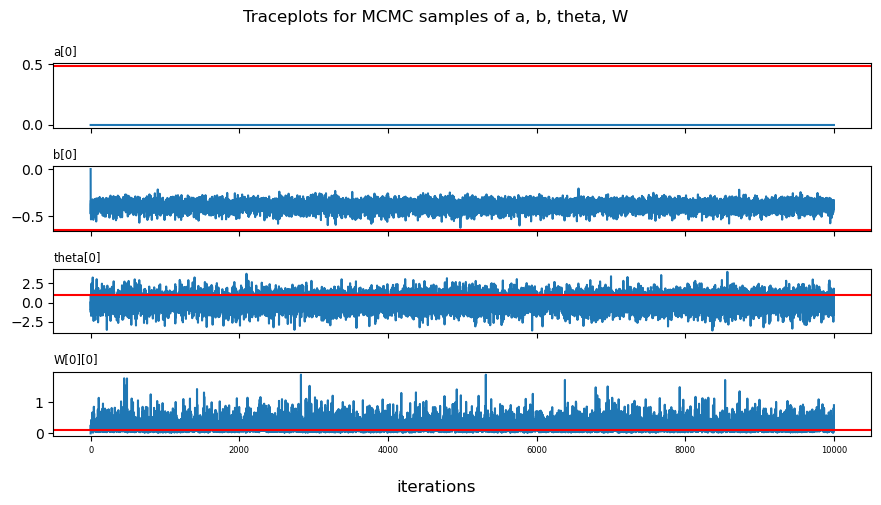

In [24]:
# Traceplots of samples
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta, W')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

ax4.plot(t, samples[3][:,0,0])
ax4.axhline(true_W[0][0], color="red")
ax4.set_title("W[0][0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

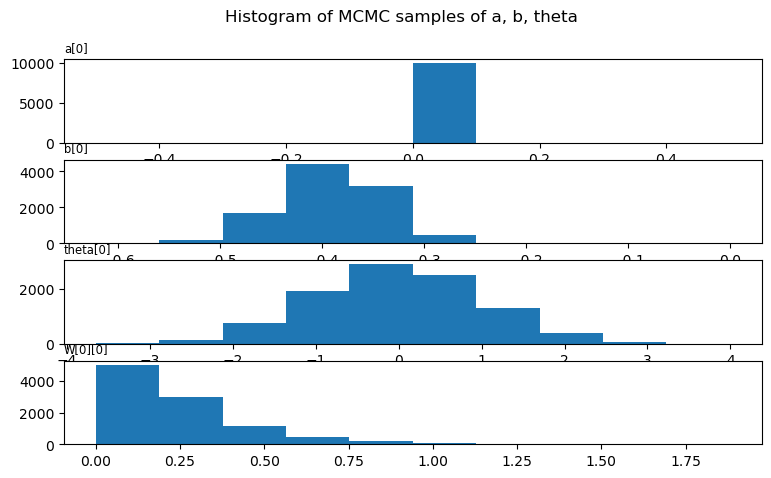

In [25]:
# Histogram of samples
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')
ax4.hist(samples[3][:,0,0])
ax4.set_title("W[0][0]", fontsize='small', loc='left')

plt.show()